# The simple pendulum



<IPython.core.display.Javascript object>


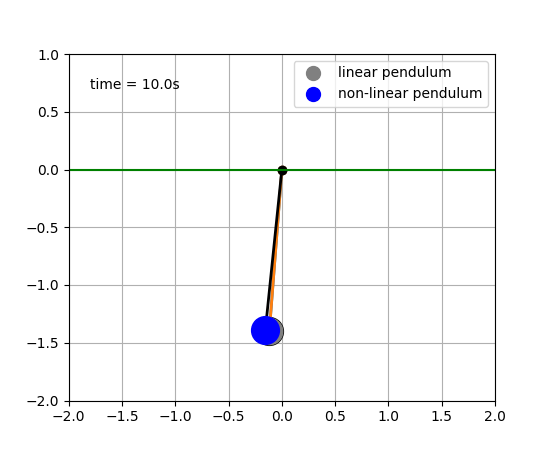

In [1]:
%matplotlib notebook
#%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import scipy.integrate as integrate
from numpy import sin, cos
pi = np.pi


""" THE USER INPUT : damping amount and initial conditions
    
    dampFactor: changing the dampFactor, you are effectively modifying the damping coefficient $b$
    -----------------------------------------------------------------------------------------------
    - dampFactor = 0, means b = 0 and hence there is no damping. The result is simple harmonic motion.
    - dampFactor = 1, means that b will be equal to the critical damping of the system (the quickest way to equilibium)
    - dampFactor < 1, means that b is smaller than the critical damping (oscillations will eventually die out)
    - dampFactor > 1, means that b is larger than the critical damping ()
    
    th0: the initial angular displacement
    -------------------------------------
    - defines from which angle the pendulum is suspended. Note that the simple pendulum approximation is valid 
      only for relatively small angles.
      
    dth0: the initial angular velocity
    -------------------------------------
    - dth0 = 0 means that the pendulum is suspended without applying force.
    - dth0 > 0 means that an instantaneous force is applied at t = 0 (the pendulum is pushed while suspended)
               
"""
dampFactor = 0
th0 = -pi/12   # Initial angular displacement
dth0 = 0      # Initial angular velocity


""" Physical properties of the system
"""
G = 9.8    # Acceleration due go gravity
L = 1.4    # Length of the pendulum in meters
m = 1      # Mass of the pendulum in kg  KEEP THE MASS to 1, otherwise the code will not be correct when damping present
c = G/L
criticalDamping = np.sqrt(4*c)
dampCoef = criticalDamping*dampFactor



""" Setting up the differential equation
"""
# create a time array for 10 seconds sampled at dt seconds
dt = 0.01
t = np.arange(0.0, 20, dt)

tdense = np.arange(0.0, 5, dt/4 )



# The imaginary part of the root of the characteristic equation
tmp = dampCoef**2 - criticalDamping**2
a = np.sqrt(np.abs(tmp))


""" Solving the differential equation (analytically, the simple pendulum can be solved in closed form)
"""
# Use the initial conditions to solve the differential equation for the four cases
if dampCoef > 0: 
    
    if tmp < 0: # underdamped (oscillatory but eventually comes to a rest)
        w = a/2
        C1 = th0
        C2 = (dth0 + th0 * dampCoef/2 )/w     
        # We solved the ODE in analytical form so we can just evaluate it
        th = C1*np.exp(-0.5*dampCoef*t)*cos(w*t) + C2*np.exp(-0.5*dampCoef*t)*sin(w*t)

    elif  tmp == 0: # critically damped (the fastest trajectory to equilibrium)
        C1 = th0
        C2 = dth0 + th0 * dampCoef/2
        th = C1*np.exp(-0.5*dampCoef*t) + C2*np.exp(-0.5*dampCoef*t)*t

    elif  tmp > 0:  # overdamped (no oscillatory component)

        s1 = 0.5*(-dampCoef + a)
        s2 = 0.5*(-dampCoef - a)
        C1 = (dth0 - s2*th0)/(s1-s2)
        C2 = th0-C1
        th = C1*np.exp(s1*t) + C2*np.exp(s2*t)

else: # if the damping coefficient is equal to zero we get the simple harmonic motion

    C1 = th0
    C2 = dth0/np.sqrt(G/L)
    w = np.sqrt(G/L)
    th = C1*cos(w*t) + C2*sin(w*t)


# From this, we can get the positions of the pendulum
xx = L*sin(th)
yy = -L*cos(th)



""" Solving the differential equation numerically
"""

B = dampCoef
initZ1 = th0   # initial conditions
initZ2 = dth0  # initial conditions

def odeModel(Z,t,B,c):
    
    dzdt1 = Z[1]
    dzdt2 = -B*Z[1]-c*Z[0]  
    return [dzdt1, dzdt2]


# now call the solver, evaluate at the same time instants t as the analytical solution
numsol = integrate.odeint(odeModel,[initZ1,initZ2],t,args = (B,c))
th_numerical = numsol[:,0]
xx_numerical = L*sin(th_numerical)
yy_numerical = -L*cos(th_numerical)


""" Solving the non-linear pendulum numerically
"""
def odeModel_nonlinear(Z,t,B,c):
    
    dzdt1 = Z[1]
    dzdt2 = -B*Z[1]-c*sin(Z[0])  
    return [dzdt1, dzdt2]

numsol_nonlin = integrate.odeint(odeModel_nonlinear,[initZ1,initZ2],t,args = (B,c))
th_nonlin = numsol_nonlin[:,0]
xx_nonlin = L*sin(th_nonlin)
yy_nonlin = -L*cos(th_nonlin)


""" Creating the animation with matplotlib
"""

# THE ANIMATION
fig = plt.figure(figsize =(5.5,4.5))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([0,xx[0]], [0,yy[0]], 'o-', lw=2)
ball, = ax.plot([xx[0]], [yy[0]], 'o', lw=2, markersize = 20, color = 'black')

line_numerical, = ax.plot([0,xx_numerical[0]], [0,yy_numerical[0]], 'o-', lw=2)
ball_numerical, = ax.plot([xx_numerical[0]], [yy_numerical[0]], 'o', lw=2, markersize = 19, color = 'grey')
ball_numerical_legend, = ax.plot([xx_numerical[0]], [yy_numerical[0]], 'o', lw=2, markersize = 10, color = 'grey')


line_nonlin, = ax.plot([0,xx_nonlin[0]], [0,yy_nonlin[0]], 'o-', lw=2, color = 'black')
ball_nonlin, = ax.plot([xx_nonlin[0]], [yy_nonlin[0]], 'o', lw=2, markersize = 20, color = 'blue')
ball_nonlin_legend, = ax.plot([xx_nonlin[0]], [yy_nonlin[0]], 'o', lw=2, markersize = 10, color = 'blue')

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ax.legend((ball_numerical_legend, ball_nonlin_legend), ('linear pendulum', 'non-linear pendulum'))
ball_numerical_legend.remove()
ball_nonlin_legend.remove()

def init():

    thisx = [0, xx[0]]
    thisy = [0, yy[0]]
    
    thisx_numerical = [0, xx_numerical[0]]
    thisy_numerical = [0, yy_numerical[0]]
    
    thisx_nonlin = [0, xx_nonlin[0]]
    thisy_nonlin = [0, yy_nonlin[0]]

    line.set_data(thisx, thisy)
    ball.set_data((thisx[1], thisy[1]))
    
    line_numerical.set_data(thisx_numerical, thisy_numerical)
    ball_numerical.set_data((thisx_numerical[1], thisy_numerical[1]))
    
    line_nonlin.set_data(thisx_nonlin, thisy_nonlin)
    ball_nonlin.set_data((thisx_nonlin[1], thisy_nonlin[1]))
    
    
    time_text.set_text('')
    ax.set_ylim(-2, 1)
    #ax.set_xlim(-0.25, 0.25)
    ax.axhline(0,color = 'green',lw = 1.5)
    
    return line, ball, line_numerical, ball_numerical, line_nonlin, ball_nonlin, time_text


def animate(i):

    # The x and y positions of the pendulum
    thisx = [0, xx[i]]
    thisy = [0, yy[i]]
    
    thisx_numerical = [0, xx_numerical[i]]
    thisy_numerical = [0, yy_numerical[i]]

    thisx_nonlin = [0, xx_nonlin[i]]
    thisy_nonlin = [0, yy_nonlin[i]]
    
    line.set_data(thisx, thisy)
    ball.set_data((thisx[1], thisy[1]))
    
    line_numerical.set_data(thisx_numerical, thisy_numerical)
    ball_numerical.set_data((thisx_numerical[1], thisy_numerical[1]))
    
    line_nonlin.set_data(thisx_nonlin, thisy_nonlin)
    ball_nonlin.set_data((thisx_nonlin[1], thisy_nonlin[1]))
    
    time_text.set_text(time_template % (i*dt))
    return line, ball, line_numerical, ball_numerical, line_nonlin, ball_nonlin, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(yy)), interval=dt*300, blit=True, init_func=init, repeat_delay = 1000)

#ani.save('damped_over.mp4', fps=1/dt)
plt.show()